https://github.com/AFAgarap/malware-classification

https://paperswithcode.com/dataset/malimg

In [ ]:
import os
from google.colab import drive
import shutil
import pickle
import random as r
import numpy as np
import pandas as pd
import seaborn as sns
import codecs
import tensorflow as tf
import sklearn
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Accessing My Google Drive
drive.mount('/content/drive')

In [ ]:
#Unzipping malware byteimage folder
!unzip drive/My\ Drive/CS\ 222/malimg_dataset.zip > /dev/null

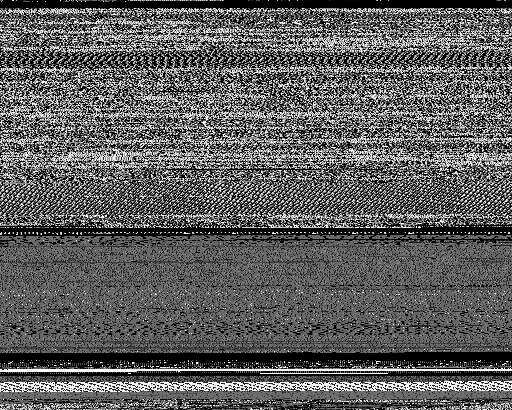

In [ ]:
#Print sample malware image
img = tf.keras.preprocessing.image.load_img('/content/malimg_paper_dataset_imgs/Adialer.C/000bde2e9a94ba41c0c111ffd80647c2.png')
img

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, Dropout
from sklearn.preprocessing import StandardScaler

# Set the path to the directory containing the subfolders
root_dir = 'malimg_paper_dataset_imgs'

images = []
labels = []
class_index = 0

# Create a dictionary to map class names to numerical labels
class_to_index = {}

# Loop through each subfolder in the directory
for subdir in sorted(os.listdir(root_dir)):
    subfolder_path = os.path.join(root_dir, subdir)
    # Check if the path is a directory
    if os.path.isdir(subfolder_path):
        # Assign a numerical label to the class
        class_to_index[subdir] = class_index
        class_index += 1
        # Loop through each file in the subfolder
        for file in sorted(os.listdir(subfolder_path)):
            # Check if the file is a PNG image
            if file.endswith('.png'):
                # Open the image using the Pillow library
                img_path = os.path.join(subfolder_path, file)
                with Image.open(img_path) as img:
                    # Resize the image to 32x32
                    img = img.resize((32, 32))
                    # Flatten the image and store as a 1x1024 array
                    img_array = np.array(img).flatten()
                    images.append(img_array)
                    # Assign the label/index to the corresponding image
                    labels.append(class_to_index[subdir])

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Standardize the features
scaler = StandardScaler()
images_standardized = scaler.fit_transform(images)


In [ ]:
images[0]

array([ 50,  52,  52, ...,  89,  95, 104], dtype=uint8)

In [ ]:
images_standardized[0]

array([-0.81570617, -0.60121165, -0.57430201, ..., -0.2831419 ,
       -0.1306164 ,  0.1108428 ])

In [ ]:
np.shape(images_standardized)

(9339, 1024)

In [ ]:
np.shape(labels)

(9339,)

In [ ]:
# Each malware class and its associated index
for key in class_to_index:
  print (key, class_to_index[key])

Adialer.C 0
Agent.FYI 1
Allaple.A 2
Allaple.L 3
Alueron.gen!J 4
Autorun.K 5
C2LOP.P 6
C2LOP.gen!g 7
Dialplatform.B 8
Dontovo.A 9
Fakerean 10
Instantaccess 11
Lolyda.AA1 12
Lolyda.AA2 13
Lolyda.AA3 14
Lolyda.AT 15
Malex.gen!J 16
Obfuscator.AD 17
Rbot!gen 18
Skintrim.N 19
Swizzor.gen!E 20
Swizzor.gen!I 21
VB.AT 22
Wintrim.BX 23
Yuner.A 24


In [ ]:
# train-test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(images_standardized, labels, test_size=0.2, train_size=0.8, random_state=27)

In [ ]:
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, Dropout
from PIL import Image
import numpy as np

# Modify the CNN for feature extraction
cnn_model = Sequential([
    Conv2D(36, (5, 5), strides=1, input_shape=(32, 32, 1), activation='linear'),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(2, 2), strides=1),
    Conv2D(72, (5, 5), strides=1, activation='linear'),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(2, 2), strides=1),
    Flatten(),
    Dense(1024, activation='linear'),
    LeakyReLU(alpha=0.01),
    Dropout(0.85),
    Dense(len(class_to_index), activation='softmax') # 25 output classes
])

# Summary of the CNN feature extractor
cnn_model.summary()

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape data to fit the input shape of the CNN
X_train_reshaped = X_train.reshape(-1, 32, 32, 1)
X_test_reshaped = X_test.reshape(-1, 32, 32, 1)

epochs = 10
batch_size = 64

# Train the CNN model
cnn_model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_reshaped, y_test))

# Extract features using the CNN (features_train and features_test)
features_train = cnn_model.predict(X_train_reshaped)
features_test = cnn_model.predict(X_test_reshaped)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(features_train, y_train)

# Predict labels for the test set and evaluate
y_pred = svm_classifier.predict(features_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 36)        936       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 36)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 36)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 72)        64872     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 23, 23, 72)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 72)        0         
 g2D)                                                   

In [2]:
# Save the models
cnn_model.save('cnn_model.h5')

from joblib import dump
dump(svm_classifier, 'svm_model.joblib')
dump(scaler, 'scaler.joblib')

NameError: name 'cnn_model' is not defined